In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
import os

In [47]:
# --- 1. 데이터 로드 및 전처리 ---
file_path = r'/content/drive/MyDrive/Colab Notebooks/TSLA.csv'


df = pd.read_csv(file_path)

# Date, Adj Close, Volume 제외
# 사용할 열: 'Open', 'High', 'Low', 'Close'
data = df[['Open', 'High', 'Low', 'Close']].values

print(f"데이터 로드 완료. (총 {len(data)}일치 데이터)")

데이터 로드 완료. (총 2956일치 데이터)


In [48]:
# --- 2. 데이터 정규화 ---
# 0과 1 사이의 값으로 스케일링
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [49]:
# --- 3. 윈도우 생성 ---
# "윈도우는 마음대로" -> 60일(약 3달)로 윈도우 크기 설정
# 60일간의 Open, High, Low 데이터를 바탕으로 61일째의 Close를 예측
window_size = 60

# 윈도우 데이터를 생성하는 헬퍼 함수
def create_dataset(dataset, window_size=60):
    X, y = [], []
    for i in range(len(dataset) - window_size):
        # 0:Open, 1:High, 2:Low (3개 피처 사용)
        features = dataset[i:(i + window_size), 0:3]
        # 3:Close (예측 대상)
        target = dataset[i + window_size, 3]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y)

In [50]:
# --- 4. 훈련/테스트 데이터 분리 ---
# 시계열 데이터이므로 순서를 섞지 않고 80%를 훈련 데이터로 사용
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]

# 테스트 데이터 생성 시, 첫 예측을 위해 윈도우 크기만큼의 훈련 데이터가 필요
test_data = scaled_data[train_size - window_size:]

# 윈도우 데이터셋 생성
X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

# Keras 모델에 입력하기 위해 (samples, time_steps, features) 형태
print(f"\n--- 데이터 형태 ---")
print(f"훈련 데이터 X shape: {X_train.shape}")
print(f"훈련 데이터 y shape: {y_train.shape}")
print(f"테스트 데이터 X shape: {X_test.shape}")
print(f"테스트 데이터 y shape: {y_test.shape}")


--- 데이터 형태 ---
훈련 데이터 X shape: (2304, 60, 3)
훈련 데이터 y shape: (2304,)
테스트 데이터 X shape: (592, 60, 3)
테스트 데이터 y shape: (592,)


In [51]:
# --- 5. 모델 구축 (RNN) ---
print("\n--- RNN 모델 구축 ---")
model_rnn = Sequential()
model_rnn.add(SimpleRNN(50, return_sequences=False, input_shape=(window_size, 3)))
model_rnn.add(Dense(25))
model_rnn.add(Dense(1)) # Close 값 1개 예측
model_rnn.compile(optimizer='adam', loss='mean_squared_error')
model_rnn.summary()


--- RNN 모델 구축 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, 50)             │         2,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,001 (15.63 KB)

 Trainable params: 4,001 (15.63 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# --- 6. 모델 구축 (LSTM) ---
print("\n--- LSTM 모델 구축 ---")
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=False, input_shape=(window_size, 3)))
model_lstm.add(Dense(25))
model_lstm.add(Dense(1)) # Close 값 1개 예측
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.summary()


--- LSTM 모델 구축 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 50)             │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,101 (47.27 KB)

 Trainable params: 12,101 (47.27 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# --- 7. 모델 훈련 ---
print("\n--- RNN 모델 훈련 시작 ---")
model_rnn.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1)
print("--- RNN 모델 훈련 완료 ---")



--- RNN 모델 훈련 시작 ---
Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.4419e-06
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.7224e-06
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.6659e-06
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.5926e-06
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.5251e-06
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.3373e-06
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.2325e-06
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.4724e-06
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.3459e-06
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.1825e-06
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0473e-06
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0950e-06
Epoch 13/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.3663e-06
Epoch 14/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.19

In [59]:
print("\n--- LSTM 모델 훈련 시작 ---")
model_lstm.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1)
print("--- LSTM 모델 훈련 완료 ---")


--- LSTM 모델 훈련 시작 ---
Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.7039e-04
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 3.6708e-06
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 3.7376e-06
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.6340e-06
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.4510e-06
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.2507e-06
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.1516e-06
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.9443e-06
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 3.3436e-06
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 3.1541e-06
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.6261e-06
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.2742e-06
Epoch 13/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.0209e-06
Epoch 14/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 2.7

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

--- 모델 평가 (RMSE) ---
RNN 모델 RMSE: 51.4074
LSTM 모델 RMSE: 44.9965

결과 그래프가 tesla_prediction_rnn_vs_lstm.png 파일로 저장되었습니다.


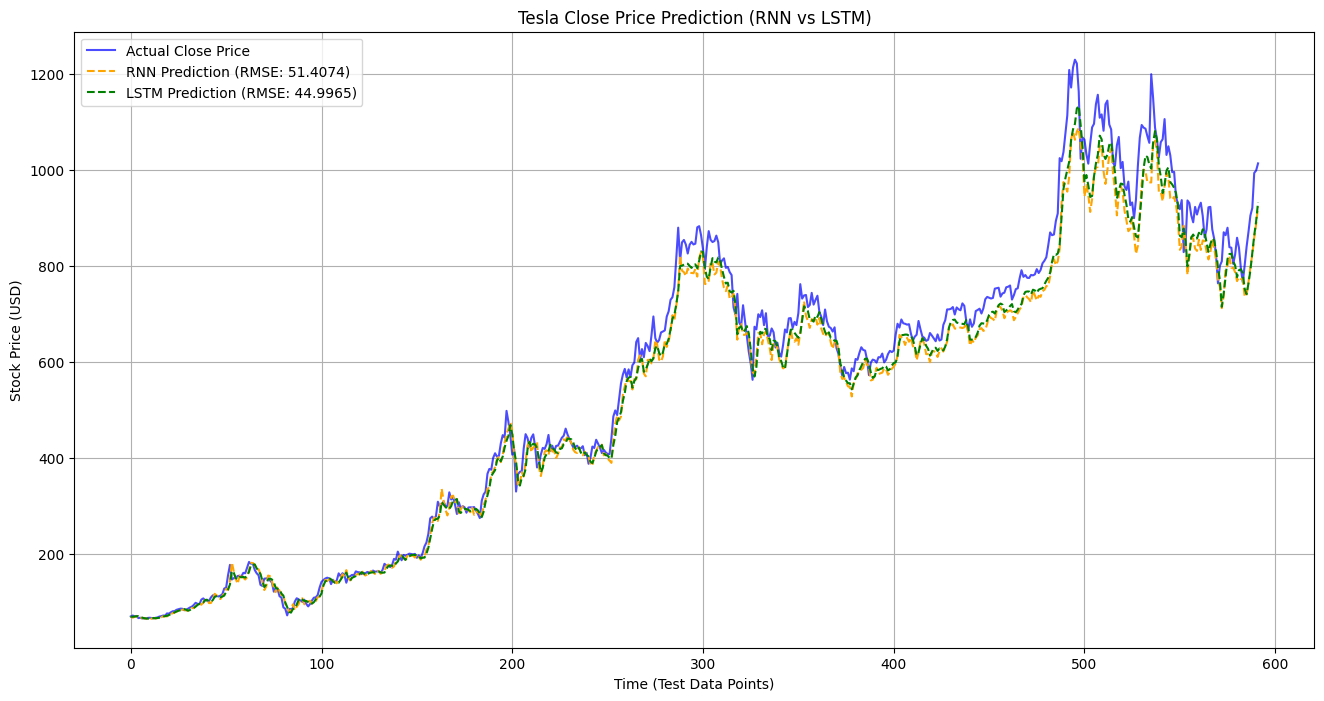

In [62]:
# --- 8. 예측 및 평가 ---
# RNN 예측
predictions_rnn = model_rnn.predict(X_test)
# LSTM 예측
predictions_lstm = model_lstm.predict(X_test)

# 예측값과 실제값(y_test)을 원래 스케일로 되돌리기
# scaler는 [Open, High, Low, Close] 4개 열 기준으로 학습되었음
# 따라서 Close 예측값을 되돌리려면 4개 열 형태의 더미 배열을 만들어야 함

# RNN 역변환
dummy_rnn = np.zeros((len(predictions_rnn), 4))
dummy_rnn[:, 3] = predictions_rnn.flatten() # Close 열(인덱스 3)에 예측값 삽입
inv_predictions_rnn = scaler.inverse_transform(dummy_rnn)[:, 3]

# LSTM 역변환
dummy_lstm = np.zeros((len(predictions_lstm), 4))
dummy_lstm[:, 3] = predictions_lstm.flatten() # Close 열(인덱스 3)에 예측값 삽입
inv_predictions_lstm = scaler.inverse_transform(dummy_lstm)[:, 3]

# 실제값(y_test) 역변환
dummy_y_test = np.zeros((len(y_test), 4))
dummy_y_test[:, 3] = y_test.flatten()
inv_y_test = scaler.inverse_transform(dummy_y_test)[:, 3]

# RMSE (Root Mean Squared Error) 계산
rmse_rnn = np.sqrt(mean_squared_error(inv_y_test, inv_predictions_rnn))
rmse_lstm = np.sqrt(mean_squared_error(inv_y_test, inv_predictions_lstm))

print(f"\n--- 모델 평가 (RMSE) ---")
print(f"RNN 모델 RMSE: {rmse_rnn:.4f}")
print(f"LSTM 모델 RMSE: {rmse_lstm:.4f}")

# --- 9. 결과 시각화 ---
plt.figure(figsize=(16, 8))
plt.title('Tesla Close Price Prediction (RNN vs LSTM)')
plt.xlabel('Time (Test Data Points)')
plt.ylabel('Stock Price (USD)')
plt.plot(inv_y_test, label='Actual Close Price', color='blue', alpha=0.7)
plt.plot(inv_predictions_rnn, label=f'RNN Prediction (RMSE: {rmse_rnn:.4f})', color='orange', linestyle='--')
plt.plot(inv_predictions_lstm, label=f'LSTM Prediction (RMSE: {rmse_lstm:.4f})', color='green', linestyle='--')
plt.legend()
plt.grid(True)

# 그래프 파일 저장
plot_filename = 'tesla_prediction_rnn_vs_lstm.png'
plt.savefig(plot_filename)
print(f"\n결과 그래프가 {plot_filename} 파일로 저장되었습니다.")

# 로컬 환경에서 바로 그래프 보기
plt.show()